In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.image import imread
from numpy import array
import numpy as np
from scipy.integrate import solve_ivp

In [2]:
# Data Preparation
def lorenz(t, state, sigma, beta, rho):
    x, y, z = state
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

rho_values = [10, 28, 40]
sigma = 10
beta = 8/3
delta_t = 0.01
n_samples = 10000

input_data = []
output_data = []

for rho in rho_values:
    initial_state = np.random.rand(3)
    t_span = (0, n_samples * delta_t)
    t_eval = np.linspace(0, n_samples * delta_t, n_samples)
    sol = solve_ivp(lorenz, t_span, initial_state, args=(sigma, beta, rho), t_eval=t_eval, method='RK45')

    for i in range(len(sol.t) - 1):
        input_data.append(np.append(sol.y[:, i], rho))
        output_data.append(np.append(sol.y[:, i + 1], rho))

input_data = np.array(input_data)
output_data = np.array(output_data)


## plot the trajectories for output

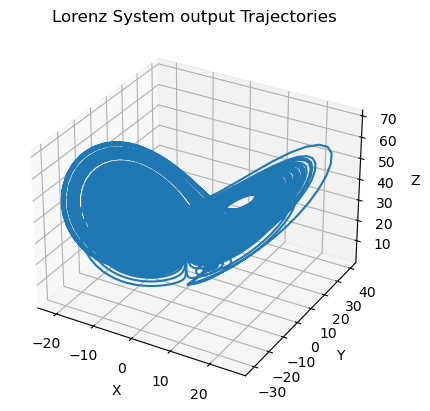

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract x, y, and z values from the outputs list
x_values = [output[0] for output in output_data]
y_values = [output[1] for output in output_data]
z_values = [output[2] for output in output_data]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectories
ax.plot(x_values, y_values, z_values)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz System output Trajectories')

# Show the plot
plt.show()


## Trajectories for input

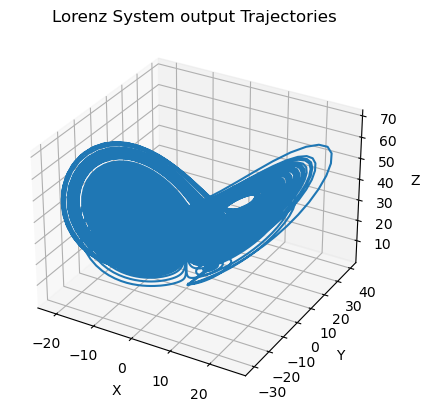

In [4]:
# Extract x, y, and z values from the outputs list
x_values = [input[0] for input in input_data]
y_values = [input[1] for input in input_data]
z_values = [input[2] for input in input_data]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectories
ax.plot(x_values, y_values, z_values)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz System output Trajectories')

# Show the plot
plt.show()

## Set NN model

In [5]:
# Neural Network Model
def init_model(num_hidden_layers=4, num_neurons_per_layer=140):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(4))

    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('relu'),
            kernel_initializer='glorot_normal'))

    model.add(tf.keras.layers.Dense(4))
    return model

model = init_model()

In [6]:
# Loss Function
def compute_lorenz_loss(model, input_data, output_data, steps):
    loss = tf.reduce_mean(tf.square(model(input_data) - output_data))
    return loss

In [7]:
# Gradient Function
def get_grad(model, input_data, output_data, steps):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = compute_lorenz_loss(model, input_data, output_data, steps)

    grad_theta = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, grad_theta

In [8]:
# Initialize model aka tilde u
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,1e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [9]:
from time import time
# Training Loop
steps = 4

@tf.function
def train_step(input_data, output_data):
    loss, grad_theta = get_grad(model, input_data, output_data, steps)
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    return loss

N = 10000
hist = []

t0 = time()

input_data_tensor = tf.convert_to_tensor(input_data, dtype=tf.float32)
output_data_tensor = tf.convert_to_tensor(output_data, dtype=tf.float32)

for i in range(N+1):
    loss = train_step(input_data_tensor, output_data_tensor)
    hist.append(loss.numpy())

    if i % 50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i, loss))

print('\nComputation time: {} seconds'.format(time() - t0))

It 00000: loss = 5.01034180e+02
It 00050: loss = 2.09040618e+00
It 00100: loss = 1.07986546e+00
It 00150: loss = 4.22247313e-02
It 00200: loss = 2.57887468e-02
It 00250: loss = 7.51188695e-02
It 00300: loss = 2.59710681e-02
It 00350: loss = 1.75749958e-02
It 00400: loss = 1.48091977e-02
It 00450: loss = 1.28430920e-02
It 00500: loss = 4.00000028e-02
It 00550: loss = 1.10708106e+00
It 00600: loss = 1.93487518e-02
It 00650: loss = 1.27715766e-02
It 00700: loss = 1.05589340e-02
It 00750: loss = 9.32162814e-03
It 00800: loss = 1.82891503e-01
It 00850: loss = 1.63955502e-02
It 00900: loss = 8.61764885e-03
It 00950: loss = 7.43723940e-03
It 01000: loss = 1.83649231e-02
It 01050: loss = 9.73643549e-03
It 01100: loss = 9.22758225e-03
It 01150: loss = 8.84342380e-03
It 01200: loss = 8.51801969e-03
It 01250: loss = 8.24141689e-03
It 01300: loss = 8.00164137e-03
It 01350: loss = 7.79168075e-03
It 01400: loss = 7.60898646e-03
It 01450: loss = 7.44748861e-03
It 01500: loss = 7.30192661e-03
It 01550

1/1 [==============================] - 0s 19ms/step


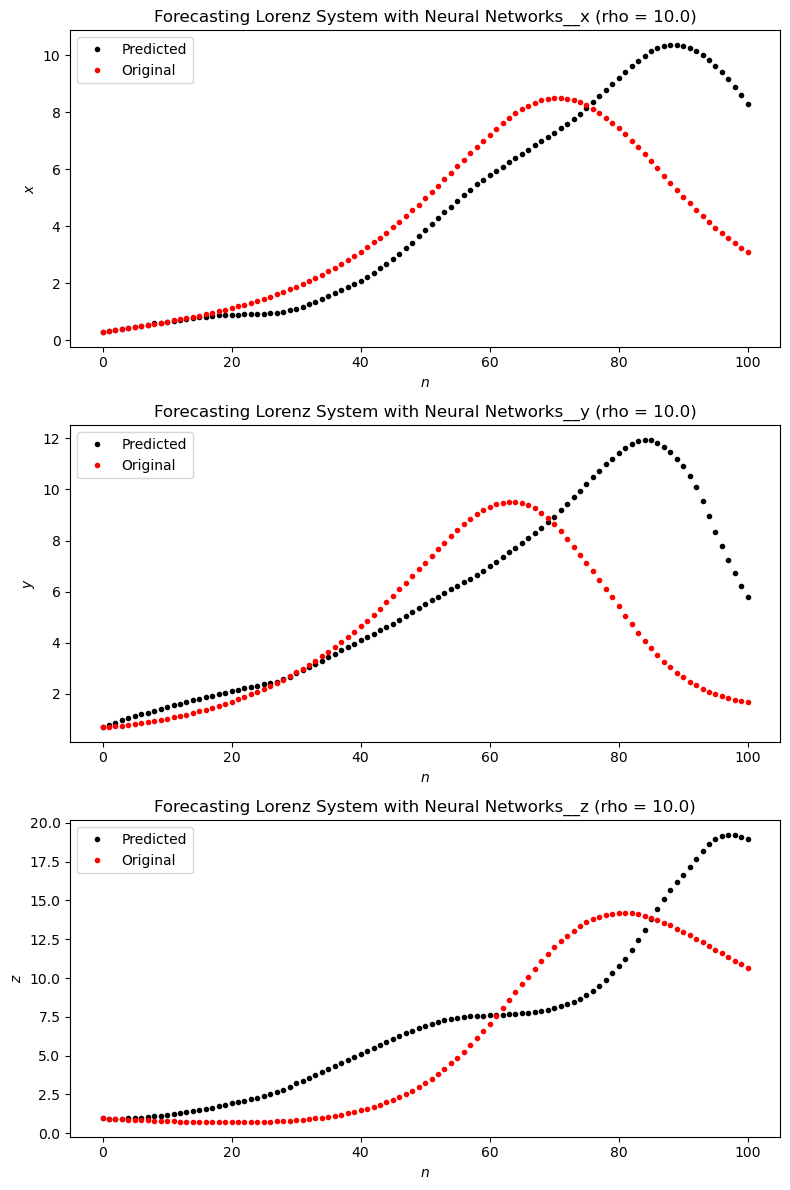

1/1 [==============================] - 0s 19ms/step


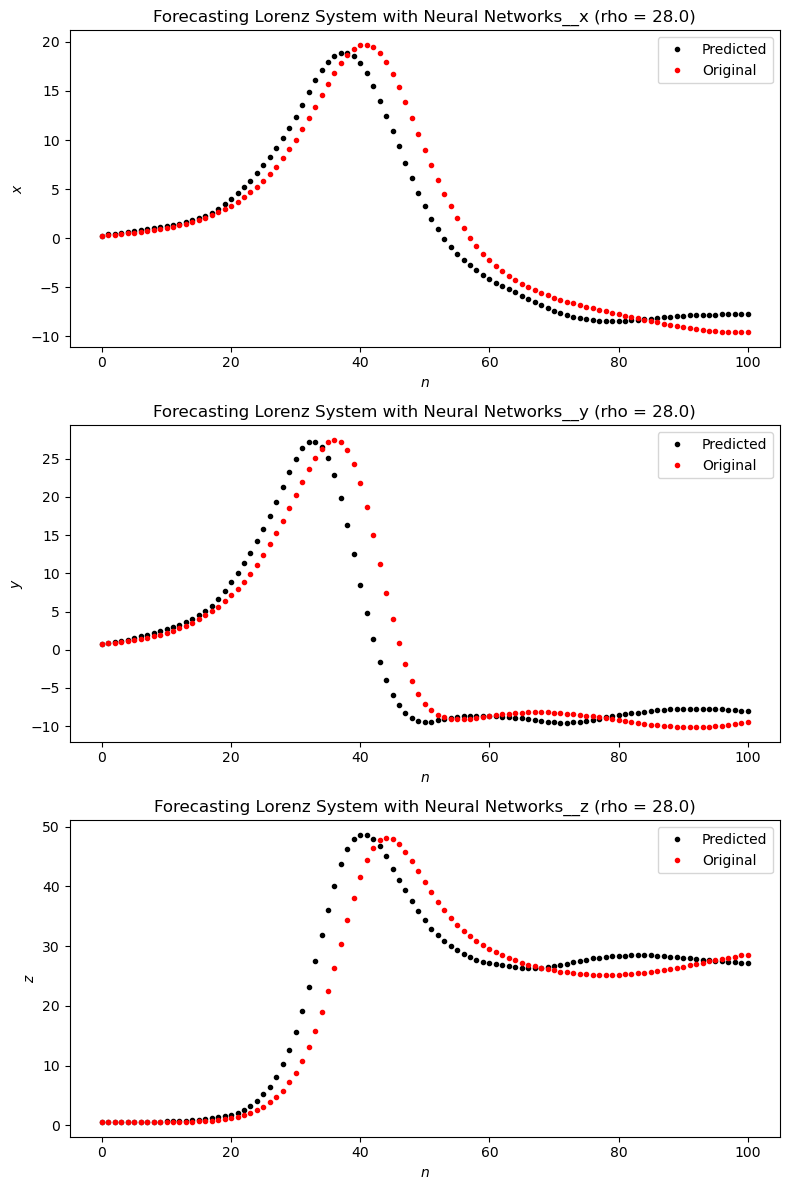

1/1 [==============================] - 0s 14ms/step


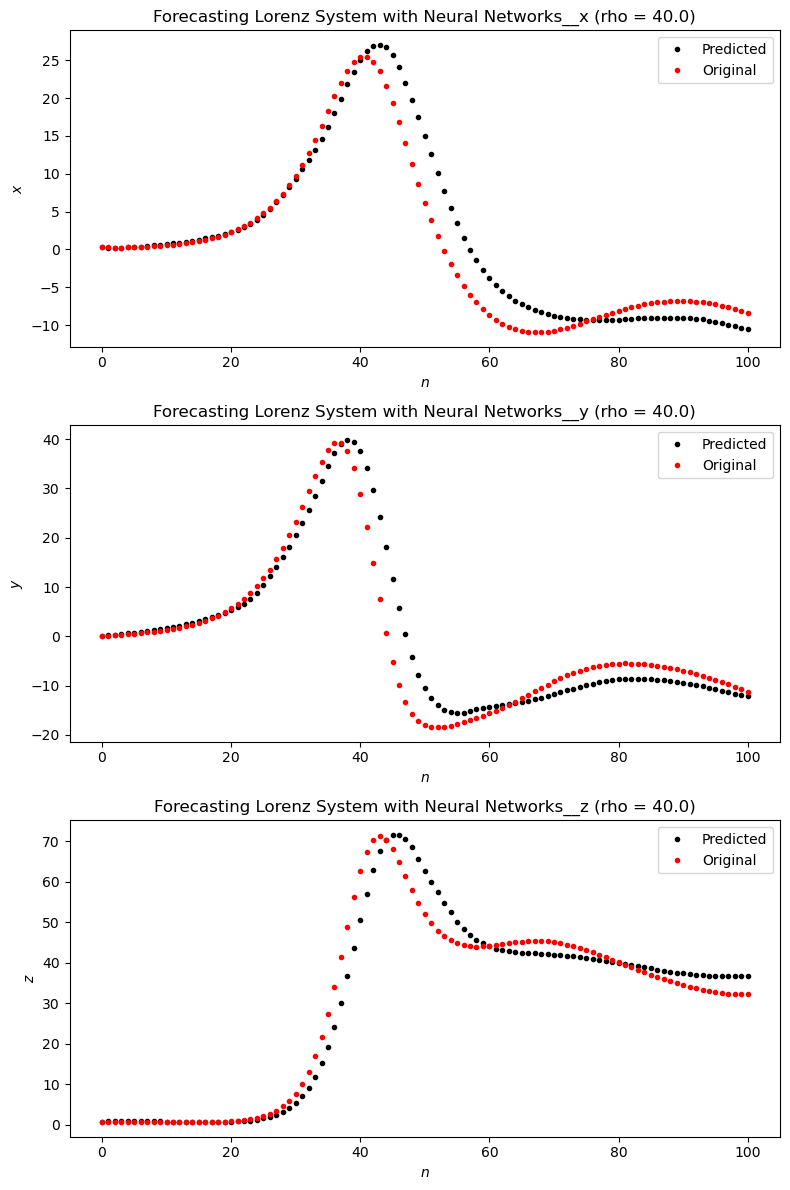

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Use Trained Model to Forecast
M = 101

unique_rho_values = np.unique(input_data[:, 3])

for rho in unique_rho_values:
    # Get the index of the first occurrence of the current rho value in the input data
    index = np.where(input_data[:, 3] == rho)[0][0]

    # Initial conditions for Lorenz system
    x0, y0, z0, rho0 = input_data[index]

    # Create an array to store the predicted trajectory
    predicted_trajectory = np.zeros((M, 4))
    predicted_trajectory[0] = [x0, y0, z0, rho0]

    # Forecast the Lorenz trajectory using the trained model
    for m in range(1, M):
        predicted_trajectory[m] = model.predict(np.expand_dims(predicted_trajectory[m-1], axis=0))

    # Extract the predicted x, y, z values
    predicted_x = predicted_trajectory[:, 0]
    predicted_y = predicted_trajectory[:, 1]
    predicted_z = predicted_trajectory[:, 2]

    # Extract the original x, y, z values from the input data
    original_x = input_data[index:index+M, 0]
    original_y = input_data[index:index+M, 1]
    original_z = input_data[index:index+M, 2]

    # Plot the predicted and original trajectories
    fig, axes = plt.subplots(3, 1, figsize=(8, 12))
    axes[0].plot(predicted_x, 'k.', label='Predicted')
    axes[0].plot(original_x, 'r.', label='Original')
    axes[0].set_title(f'Forecasting Lorenz System with Neural Networks__x (rho = {rho})')
    axes[0].set_xlabel('$n$')
    axes[0].set_ylabel('$x$')
    axes[0].legend()

    axes[1].plot(predicted_y, 'k.', label='Predicted')
    axes[1].plot(original_y, 'r.', label='Original')
    axes[1].set_title(f'Forecasting Lorenz System with Neural Networks__y (rho = {rho})')
    axes[1].set_xlabel('$n$')
    axes[1].set_ylabel('$y$')
    axes[1].legend()

    axes[2].plot(predicted_z, 'k.', label='Predicted')
    axes[2].plot(original_z, 'r.', label='Original')
    axes[2].set_title(f'Forecasting Lorenz System with Neural Networks__z (rho = {rho})')
    axes[2].set_xlabel('$n$')
    axes[2].set_ylabel('$z$')
    axes[2].legend()

    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


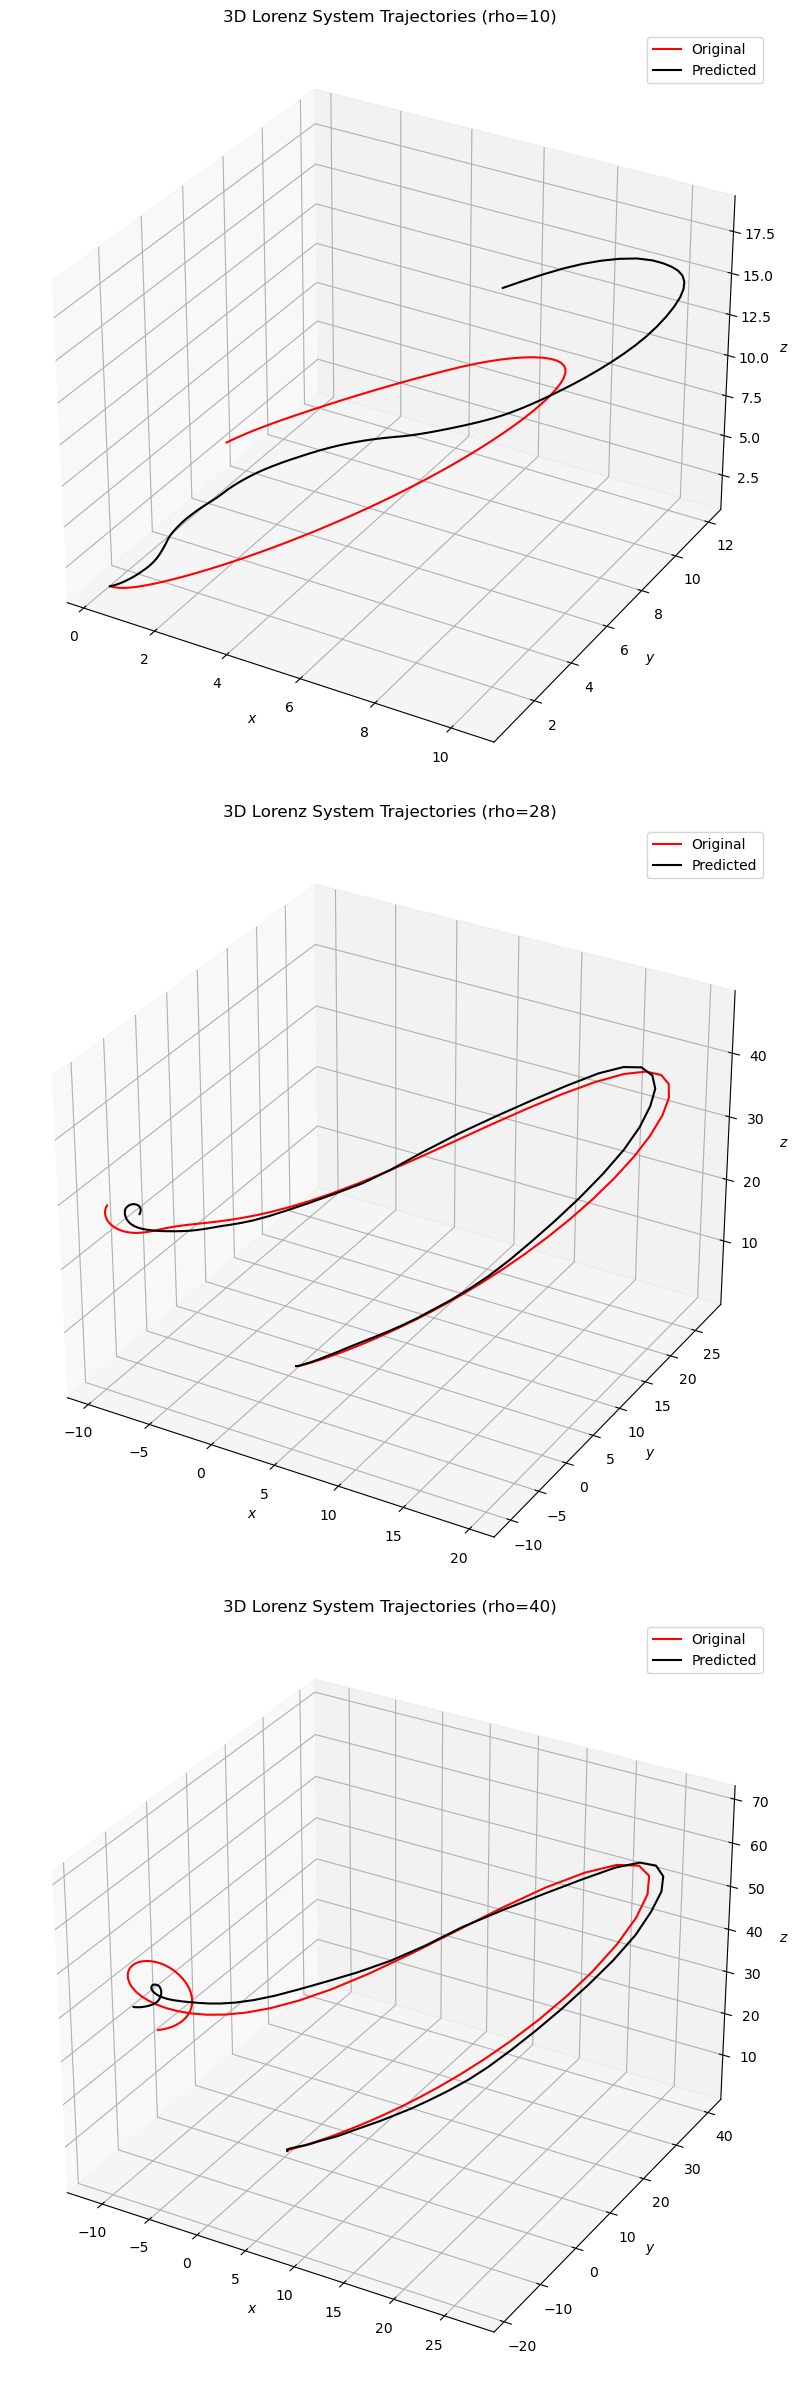

In [11]:
from mpl_toolkits.mplot3d import Axes3D

fig, axes = plt.subplots(3, 1, figsize=(12, 24), subplot_kw={'projection': '3d'})

for i, rho in enumerate(rho_values):
    # Find the index of the first occurrence of the given rho value in the input data
    idx = np.where(input_data[:, -1] == rho)[0][0]

    # Forecast the trajectory using the trained model for the given rho value
    predicted_trajectory = np.zeros((M, 4))
    predicted_trajectory[0] = input_data[idx]
    for m in range(1, M):
        predicted_trajectory[m] = model.predict(np.expand_dims(predicted_trajectory[m-1], axis=0))

    # Extract the predicted x, y, z values
    predicted_x = predicted_trajectory[:, 0]
    predicted_y = predicted_trajectory[:, 1]
    predicted_z = predicted_trajectory[:, 2]

    # Extract the original x, y, z values from the input data
    original_x = input_data[idx:idx+M, 0]
    original_y = input_data[idx:idx+M, 1]
    original_z = input_data[idx:idx+M, 2]

    # Plot original and predicted trajectories for the given rho value
    ax = axes[i]
    ax.plot(original_x, original_y, original_z, 'r', label='Original')
    ax.plot(predicted_x, predicted_y, predicted_z, 'k', label='Predicted')

    ax.set_title(f'3D Lorenz System Trajectories (rho={rho})')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 25ms/step


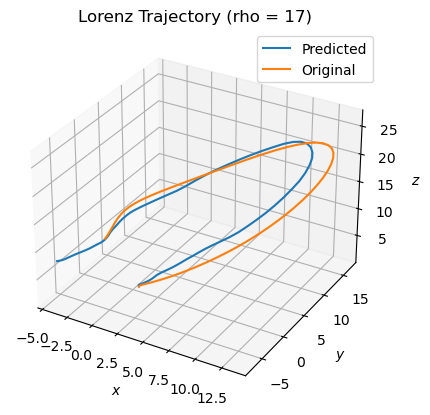

1/1 [==============================] - 0s 17ms/step


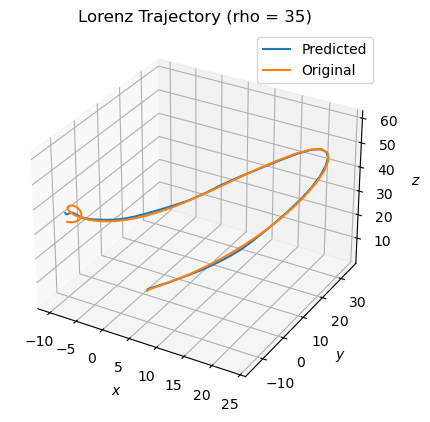

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Use Trained Model to Forecast
M = 101
new_rho_values = [17, 35]
sigma = 10
beta = 8/3
delta_t = 0.01
n_samples = M

for rho in new_rho_values:
    # Create a random initial state for the Lorenz system
    initial_state = np.random.rand(3)
    
    # Integrate the Lorenz system to obtain the original data
    t_span = (0, n_samples * delta_t)
    t_eval = np.linspace(0, n_samples * delta_t, n_samples)
    sol = solve_ivp(lorenz, t_span, initial_state, args=(sigma, beta, rho), t_eval=t_eval, method='RK45')
    
    original_trajectory = sol.y.T
    
    # Initial conditions for Lorenz system
    x0, y0, z0 = initial_state
    rho0 = rho

    # Create an array to store the predicted trajectory
    predicted_trajectory = np.zeros((M, 4))
    predicted_trajectory[0] = [x0, y0, z0, rho0]

    # Forecast the Lorenz trajectory using the trained model
    for m in range(1, M):
        predicted_trajectory[m] = model.predict(np.expand_dims(predicted_trajectory[m-1], axis=0))

    # Extract the predicted x, y, z values
    predicted_x = predicted_trajectory[:, 0]
    predicted_y = predicted_trajectory[:, 1]
    predicted_z = predicted_trajectory[:, 2]

    # Extract the original x, y, z values
    original_x = original_trajectory[:, 0]
    original_y = original_trajectory[:, 1]
    original_z = original_trajectory[:, 2]

    # Plot the predicted and original trajectories
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(predicted_x, predicted_y, predicted_z, label='Predicted')
    ax.plot(original_x, original_y, original_z, label='Original')
    ax.set_title(f'Lorenz Trajectory (rho = {rho})')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.legend()

    plt.show()


In [12]:
# Save results
!mkdir -p Lorenz_models_n120
model.save('Lorenz_models/Lorenz_step=4_rho=10_28_40')

# Save data as .mat file
import scipy.io
scipy.io.savemat('Lorenz_step=4_rho=10_28_40.mat', dict(predicted_trajectory=predicted_trajectory, original_data=input_data, steps=steps))

# Load and view saved models
saved_model = tf.keras.models.load_model('Lorenz_models/Lorenz_step=4_rho=10_28_40')
saved_model.summary()

# Check loss on training data
saved_model.compile()
loss, grad_theta = get_grad(saved_model, input_data_tensor, output_data_tensor, steps)
print('')
print('loss on training data = ', loss.numpy())


A subdirectory or file -p already exists.
Error occurred while processing: -p.


INFO:tensorflow:Assets written to: Lorenz_models/Lorenz_step=4_rho=10_28_40\assets
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 120)               600       
                                                                 
 dense_6 (Dense)             (None, 120)               14520     
                                                                 
 dense_7 (Dense)             (None, 120)               14520     
                                                                 
 dense_8 (Dense)             (None, 120)               14520     
                                                                 
 dense_9 (Dense)             (None, 4)                 484       
                                                                 
Total params: 44,644
Trainable params: 44,644
Non-trainable params: 0
_________________________________